In [119]:
import math
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
# dataset: 
# https://chronicdata.cdc.gov/Behavioral-Risk-Factors/Behavioral-Risk-Factor-Surveillance-System-BRFSS-P/
df = pd.read_csv('Behavioral_Risk.csv')

# we drop columns that have more than 50% of data missing
drop_cols = ['Data_Value_Footnote_Symbol', 'Data_Value_Footnote', 'DataSource', 'Data_value_unit', 'Data_value_type', 'QuestionID', 'ResponseID', 'LocationID', 'TopicId', 'ClassId', 'BreakoutID', 'BreakOutCategoryID', 'Display_order']

df.drop(axis=1, columns=drop_cols, inplace=True)
# irrelevant fields

df.drop(axis=1, columns=['Year', 'GeoLocation'], inplace=True)

# fill missing values with median values

nul_cols = ['Data_value', 'Confidence_limit_Low', 'Confidence_limit_High']

for col in nul_cols:
    df[col].fillna(df[col].mean(), inplace=True)


In [120]:
df['Class'].unique()

array(['Alcohol Consumption', 'Demographics', 'Cholesterol Awareness',
       'Chronic Health Indicators', 'Health Care Access/Coverage',
       'Health Status', 'Hypertension Awareness', 'Immunization',
       'Injury', 'Overweight and Obesity (BMI)', 'Physical Activity',
       'Tobacco Use', 'Colorectal Cancer Screening', 'Oral Health',
       'Prostate Cancer', "Women's Health", 'Fruits and Vegetables',
       'HIV-AIDS', 'E-Cigarette Use'], dtype=object)

In [121]:
df['Locationdesc'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Connecticut', 'Colorado', 'Delaware', 'Florida', 'Georgia',
       'District of Columbia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Nebraska', 'Montana', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'North Carolina', 'Ohio', 'New York',
       'North Dakota', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'South Carolina', 'South Dakota', 'Rhode Island', 'Tennessee',
       'Texas', 'Utah', 'Virginia', 'Washington', 'Vermont',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Guam',
       'All States and DC (median) **', 'Puerto Rico',
       'All States, DC and Territories (median) **', 'Virgin Islands'],
      dtype=object)

In [216]:
def choose_data(df, location, topic):

    result = pd.DataFrame(df.loc[df['Locationdesc']==location])
    result = pd.DataFrame(result.loc[result['Class']==topic])
    result.drop(axis=1, columns=['Locationabbr', 'Locationdesc', 'Class', 'Topic'], inplace=True)
    result.drop(axis=1, columns=['Data_value', 'Confidence_limit_Low', 'Confidence_limit_High'], inplace=True)
    result = pd.DataFrame(result.groupby(['Question', 'Break_Out_Category', 'Break_Out', 'Response']).sum())
    result.to_csv('tmp.csv')
    result = pd.read_csv('tmp.csv')
    return result

In [135]:
#TODO
#calculate data value for every break out category
def data_calculator(df):
    
    n_people = pd.DataFrame(df.groupby(['Question', 'Break_Out_Category']).sum())
    n_people.to_csv('n_people.csv')
    n_people = pd.read_csv('n_people.csv')
    j = 0
    while j<n_people.shape[0]:
        for i in range(df.shape[0]):
            if df.at[i, 'Question']==n_people.at[j, 'Question'] and df.at[i, 'Break_Out_Category']==n_people.at[j, 'Break_Out_Category']:
                df.at[i, 'Data_value'] = df.at[i, 'Sample_Size'] / n_people.at[j, 'Sample_Size'] * 100
        j+=1
    return df

In [268]:
def reformat_df(df):
    
    result = df.reset_index().pivot_table(index='Break_Out', columns=['Question', 'Response'], values=['Data_value'])
    result.to_csv('tmp.csv')
    result = pd.read_csv('tmp.csv', index_col=0, header=0)
    result.drop(['Question', 'Response', 'Break_Out'], inplace=True)
    result.astype(float, inplace=True)
    #for col in result:
        #result[col].fillna(value = result[col].mean(), inplace=True)
    #result.fillna(value=0, inplace=True)
    return result

In [263]:
def load_data(df, location, topic):
    data = choose_data(df, location, topic)
    data = data_calculator(data)
    data = reformat_df(data)
    return data

In [264]:
def calculate_cosine_similarity(df1, df2):
    
    X = df1.values
    Y = df2.values
    X = X.astype(float)
    Y = Y.astype(float)
    cos_sim = cosine_similarity(X.reshape(1, -1), Y.reshape(1, -1))
    return 1 - cos_sim

In [274]:
whealth_ny = load_data(df, 'New York', 'Women\'s Health')
whealth_texas = load_data(df, 'New York', 'Women\'s Health')
whealth_ny.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, $15,000-$24,999 to White, non-Hispanic
Data columns (total 10 columns):
Data_value      22 non-null object
Data_value.1    22 non-null object
Data_value.2    25 non-null object
Data_value.3    25 non-null object
Data_value.4    24 non-null object
Data_value.5    24 non-null object
Data_value.6    19 non-null object
Data_value.7    19 non-null object
Data_value.8    23 non-null object
Data_value.9    23 non-null object
dtypes: object(10)
memory usage: 3.1+ KB


In [228]:
calculate_cosine_similarity(whealth_ny, whealth_texas)

array([[-2.22044605e-16]])

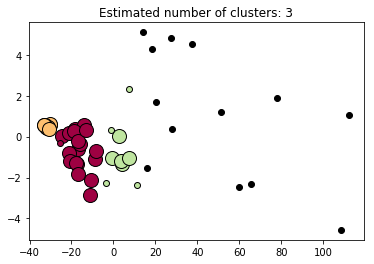

In [183]:
from sklearn.cluster import DBSCAN

X = ny_alabama.values
reduced_data = PCA(n_components=2).fit_transform(X)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

db = DBSCAN(eps=4.9).fit(reduced_data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = reduced_data[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = reduced_data[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [138]:
# tobacco use array for all states
tobacco_use_general = []
for state in df['Locationdesc'].unique():
    tmp = choose_data(state, 'Tobacco Use')
    tmp = data_calculator(tmp)
    tmp = reformat_df(tmp)
    tobacco_use_general.append(tmp)
    

In [139]:
tobacco_data = pd.concat(tobacco_use_general)

In [140]:
tobacco_data.head()

,Data_value,Data_value.1,Data_value.2,Data_value.3,Data_value.4,Data_value.5,Data_value.6,Data_value.7,Data_value.8
"$15,000-$24,999",16.406334450329695,5.2102475408063995,0.5182447644535066,20.203049997876047,0.4162949747249479,5.539941627932116,10.866392822397579,3.826613339098476,1.3836342017079235
"$25,000-$34,999",9.488163441790077,2.329477894281699,0.3313368166178157,10.938362856293276,0.19540376364640416,3.2509998919035783,6.237163549886499,1.721435520484272,0.6080423737974273
"$35,000-$49,999",11.669008755810182,2.348394768133175,0.41204706681959136,13.257720572617988,0.19965167155176078,4.145497784023349,7.523510971786834,1.6890065938817427,0.6593881742514323
"$50,000+",31.50740460490758,4.272511079883256,1.159678858162355,35.53374962830806,0.700904804383841,10.042157604583288,21.46524700032429,3.0888552588909306,1.1836558209923251
18-24,4.057628823156468,1.0778076561509369,0.18787361229718189,5.024765157984628,0.2049530315969257,0.3476093657768741,3.7100194573795937,0.7301982903740627,0.3476093657768741


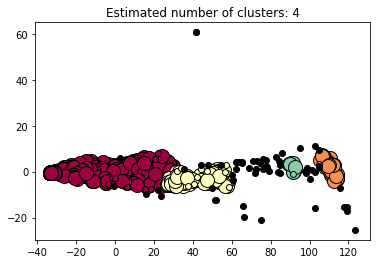

In [189]:
from sklearn.cluster import DBSCAN

X = tobacco_data.values
reduced_data = PCA(n_components=2).fit_transform(X)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

db = DBSCAN(eps=2.5).fit(reduced_data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = reduced_data[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = reduced_data[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()